In [12]:
pwd

'C:\\Users\\deepe\\Trading'

0
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
1
none of the stoplosses were hit and time limit is reached
2
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
3
none of the stoplosses were hit and time limit is reached
4
none of the stoplosses were hit and time limit is reached
5
none of the stoplosses were hit and time limit is reached
6
cannot convert float NaN to integer
C:\Users\deepe\OneDrive\Desktop\NLP\New folder\New folder_2021-01-12.parquet
7
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
8
none of the stoplosses were hit and time limit is reached
9
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
10
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
11
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited base

pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
92
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
93
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
94
none of the stoplosses were hit and time limit is reached
95
none of the stoplosses were hit and time limit is reached
96
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time


<AxesSubplot:>

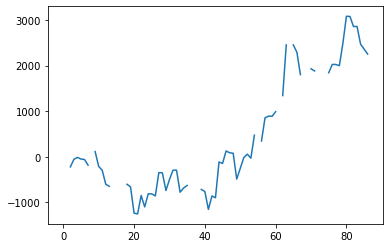

In [9]:
#import libraries
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from dateutil.relativedelta import relativedelta, TH

#fetch all the files from the diretory
path = pd.DataFrame(glob(r'C:\Users\deepe\OneDrive\Desktop\NLP\New folder\*'),columns=['location'])
path['data_date'] = path['location'].apply(lambda x: x.split('_')[-1].split('.')[0])
path['data_date'] = path['data_date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
path = path.sort_values(['data_date'])
path.reset_index(drop=True,inplace=True)

intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','Future_Traded_Price','ATM','Days_to_Expiry','CE_Symbol','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Symbol','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])

for index, row in path.iterrows():
    
    try:
        print(index)
        

        data = pd.read_parquet(row['location'])
        
           
        #change the entry and exit time according to the requirements  
        #In this case it is 9:19 am and 3:15 pm 
        a = datetime.time(9,19)
        b = datetime.time(15,15)
        entry_datetime = datetime.datetime.combine(row['data_date'].date(),a)
        exit_datetime = datetime.datetime.combine(row['data_date'].date(),b)
        


        #I-CurrentMonth
        #II-NextMonth
        #III-NextToNextMonth
        data['expiry_type'] = np.where((data['instrument_type'] == 'FUT'),data['ticker'].apply(lambda x: x.split('-')[-1].split('.')[0]),'')

        future_expiry_offset = 'I'
        instrument = 'BANKNIFTY'
        base = 100

        futures_data = data[(data['instrument_type'] == 'FUT') & (data['instrument_name'] == instrument) & (data['expiry_type'] == future_expiry_offset)]
        futures_data.reset_index(drop=True,inplace=True)

       
    
    
     
        
        
        pseudo_data = data[(data['instrument_name'] == 'BANKNIFTY') & (data['datetime'] == entry_datetime)]

        # find the index of strike price whose price is near 150 Rs 
        pseudo_index= pseudo_data['open'].sub(150).abs().idxmin()
        
        #get the strike price 
        atm = data['strike_price'].iloc[pseudo_index]

        #this 27263 is not readable convert it into base terms as strike price are in gap of 100 
        atm = base*round(atm/base) 
        
    
        
        
        nearest_expiry = row['data_date'].date() + relativedelta(weekday=TH(+1))

        ce_data = data[(data['instrument_type'] == 'CE') & (data['instrument_name'] == instrument) & ((data['expiry_date'] == nearest_expiry)|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=1))|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=2))) & (data['strike_price'] == atm)]
        ce_data.reset_index(drop=True,inplace=True)

        pe_data = data[(data['instrument_type'] == 'PE') & (data['instrument_name'] == instrument) & ((data['expiry_date'] == nearest_expiry)|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=1))|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=2))) & (data['strike_price'] == atm)]
        pe_data.reset_index(drop=True,inplace=True)

        ce_symbol = ce_data['ticker'].iloc[0]
        pe_symbol = pe_data['ticker'].iloc[0]
        

        futures_data = futures_data[['datetime','close']].set_index('datetime')
        ce_data = ce_data[['datetime','close']].set_index('datetime')
        pe_data = pe_data[['datetime','close']].set_index('datetime')

        intraday_data = pd.concat([futures_data,ce_data,pe_data],axis=1)
        intraday_data.columns = ['futures_close','ce_close','pe_close']
        intraday_data = intraday_data.ffill()

        #pd.set_option('display.max_rows',400)

        intraday_data.reset_index(inplace=True)

        traded_prices = intraday_data[intraday_data['datetime'] == entry_datetime]

        futures_entry_price = traded_prices['futures_close'].iloc[0]
        ce_entry_price = traded_prices['ce_close'].iloc[0]
        pe_entry_price = traded_prices['pe_close'].iloc[0]

        stop_loss_percentage = 30/100 #change the percentage according to the requirements 

        ce_stop_loss = ce_entry_price + ce_entry_price*stop_loss_percentage

        pe_stop_loss = pe_entry_price + pe_entry_price*stop_loss_percentage

        entry_time_index = intraday_data[intraday_data['datetime'] == entry_datetime].index[0]

        exit_time_index = intraday_data[intraday_data['datetime'] == exit_datetime].index[0]

        intraday_data = intraday_data[entry_time_index:exit_time_index+1]

        intraday_data['ce_pnl'] = 0
        intraday_data['pe_pnl'] = 0

        intraday_data.reset_index(drop=True,inplace=True)

        ce_stop_loss_counter = 0
        pe_stop_loss_counter = 0
        ce_exit_datetime = ''
        pe_exit_datetime = ''
        ce_exit_price = 0
        pe_exit_price = 0
        ce_pnl = 0
        pe_pnl = 0
        pnl = 0

        for index, row in intraday_data.iterrows():
            ce_ltp = row['ce_close']
            pe_ltp = row['pe_close']

            #criterias for exit
            #none of the stoplosses were hit and time limit is reached
            if (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0) & (row['datetime'] == exit_datetime):

                ce_pnl = ce_entry_price - ce_ltp
                pe_pnl = pe_entry_price - pe_ltp

                ce_stop_loss_counter = 1
                pe_stop_loss_counter = 1

                ce_exit_datetime = row['datetime']
                pe_exit_datetime = row['datetime']

                ce_exit_price = ce_ltp
                pe_exit_price = pe_ltp

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                print('none of the stoplosses were hit and time limit is reached')

                pnl = ce_pnl + pe_pnl

                break

            #ce stop loss is hit and none were hit till now
            elif (ce_ltp >= ce_stop_loss) & (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0):

                ce_pnl = ce_entry_price - ce_stop_loss
                pe_pnl = pe_entry_price - pe_ltp

                ce_stop_loss_counter = 1

                ce_exit_datetime = row['datetime']

                ce_exit_price = ce_stop_loss
                
                #if one stoploss is hit then change the other one to its selling price 
                pe_stop_loss = pe_entry_price

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                print('ce stop loss is hit and none were hit till now')

                pnl = ce_pnl + pe_pnl


            #pe stop loss is hit and none were hit till now
            elif (pe_ltp >= pe_stop_loss) & (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0):

                ce_pnl = ce_entry_price - ce_ltp
                pe_pnl = pe_entry_price - pe_stop_loss

                pe_stop_loss_counter = 1

                pe_exit_datetime = row['datetime']
                
                
                #if one stoploss is hit then change the other one to its selling price 
                ce_stop_loss = ce_entry_price

                pe_exit_price = pe_stop_loss

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                print('pe stop loss is hit and none were hit till now')

                pnl = ce_pnl + pe_pnl


            #either ce or pe sl was hit and now other one is also hit
            elif (ce_stop_loss_counter == 1) & (pe_stop_loss_counter == 0):

                if (pe_ltp >= pe_stop_loss) & (row['datetime'] < exit_datetime):

                    pe_pnl = pe_entry_price - pe_stop_loss

                    pe_stop_loss_counter = 1

                    pe_exit_price = pe_stop_loss

                    pe_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('ce sl was hit and now other one is also hit')

                    pnl = ce_pnl + pe_pnl

                    break


                elif (row['datetime'] == exit_datetime):

                    pe_pnl = pe_entry_price - pe_ltp

                    pe_stop_loss_counter = 1

                    pe_exit_price = pe_ltp

                    pe_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('pe sl was hit and now other exited based on exit time')

                    pnl = ce_pnl + pe_pnl

                    break


            #either ce or pe sl was hit and now other one is also hit
            elif (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 1):

                if (ce_ltp >= ce_stop_loss) & (row['datetime'] < exit_datetime):

                    ce_pnl = ce_entry_price - ce_stop_loss

                    ce_stop_loss_counter = 1

                    ce_exit_price = ce_stop_loss

                    ce_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('pe sl was hit and now other one is also hit')

                    pnl = ce_pnl + pe_pnl

                    break


                elif (row['datetime'] == exit_datetime):

                    ce_pnl = ce_entry_price - ce_ltp

                    ce_stop_loss_counter = 1

                    ce_exit_price = ce_ltp

                    ce_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('ce sl was hit and now other exited based on exit time')

                    pnl = ce_pnl + pe_pnl

                    break


            #update the pnl during the normal course of the day
            elif (((ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0)) | ((ce_stop_loss_counter == 1) & (pe_stop_loss_counter == 0))  | ((ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 1)) | ((ce_stop_loss_counter == 1) & (pe_stop_loss_counter == 1))) or row['datetime'] <= exit_datetime:

                ce_pnl = ce_entry_price - ce_ltp
                pe_pnl = pe_entry_price - pe_ltp

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                pnl = ce_pnl + pe_pnl

        intraday_trade_log = intraday_trade_log.append({'Entry_Datetime':entry_datetime,
                                                        'Future_Traded_Price':futures_entry_price,
                                                        'ATM':atm,
                                                        'Days_to_Expiry':(nearest_expiry - entry_datetime.date()).days,
                                                        'CE_Symbol':ce_symbol,
                                                        'CE_Entry_Price':ce_entry_price,
                                                        'CE_Exit_Price':ce_exit_price,
                                                        'CE_Exit_Datetime':ce_exit_datetime,
                                                        'PE_Symbol':pe_symbol,
                                                        'PE_Entry_Price':pe_entry_price,
                                                        'PE_Exit_Price':pe_exit_price,
                                                        'PE_Exit_Datetime':pe_exit_datetime,
                                                        'PnL':pnl},ignore_index=True)
    except Exception as e:
        print(e)
        print(row['location'])

intraday_trade_log['PnL'].cumsum().plot()

In [10]:
intraday_trade_log

,Entry_Datetime,Future_Traded_Price,ATM,Days_to_Expiry,CE_Symbol,CE_Entry_Price,CE_Exit_Price,CE_Exit_Datetime,PE_Symbol,PE_Entry_Price,PE_Exit_Price,PE_Exit_Datetime,PnL
0,2021-01-04 09:19:00,31530.00,32000,3,BANKNIFTY07JAN2132000CE,125.50,64.850,2021-01-04 15:15:00,BANKNIFTY07JAN2132000PE,633.70,823.81,2021-01-04 10:57:00,-129.460
1,2021-01-05 09:19:00,31077.65,34000,2,BANKNIFTY07JAN2134000CE,5.30,4.250,2021-01-05 15:15:00,BANKNIFTY07JAN2134000PE,NaN,2798.30,2021-01-05 15:15:00,NaN
2,2021-01-06 09:19:00,31908.00,31700,1,BANKNIFTY07JAN2131700CE,308.90,401.570,2021-01-06 12:32:00,BANKNIFTY07JAN2131700PE,168.00,168.00,2021-01-06 13:48:00,-92.670
3,2021-01-07 09:19:00,32179.45,31500,0,BANKNIFTY07JAN2131500CE,602.85,450.650,2021-01-07 15:15:00,BANKNIFTY07JAN2131500PE,13.30,0.20,2021-01-07 15:15:00,165.300
4,2021-01-08 09:19:00,32243.70,31700,6,BANKNIFTY14JAN2131700CE,682.05,619.950,2021-01-08 15:15:00,BANKNIFTY14JAN2131700PE,176.85,197.15,2021-01-08 15:15:00,41.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2021-05-25 09:19:00,34961.95,35800,2,BANKNIFTY27MAY2135800CE,93.05,31.350,2021-05-25 15:15:00,BANKNIFTY27MAY2135800PE,938.30,1219.79,2021-05-25 13:43:00,-219.790
83,2021-05-26 09:19:00,34570.00,34400,1,BANKNIFTY27MAY2134400CE,372.85,484.705,2021-05-26 10:39:00,BANKNIFTY27MAY2134400PE,200.75,88.05,2021-05-26 15:15:00,0.845
84,2021-05-27 09:19:00,34630.05,32500,0,BANKNIFTY27MAY2132500CE,2187.95,2578.000,2021-05-27 15:15:00,BANKNIFTY27MAY2132500PE,2.45,0.15,2021-05-27 15:15:00,-387.750
85,2021-05-28 09:19:00,35466.05,36700,6,BANKNIFTY03JUN2136700CE,110.35,62.600,2021-05-28 15:15:00,BANKNIFTY03JUN2136700PE,1427.90,1585.05,2021-05-28 15:15:00,-109.400


In [11]:
intraday_trade_log.to_csv('backtest.csv')